In [1]:
import os, sys, glob
import logging
import numpy as np
import pandas as pd
import matplotlib
from matplotlib.colors import LogNorm
from matplotlib import pyplot as plt
from scipy.interpolate import UnivariateSpline

from signal_generator import SignalGenerator
from background_generator import BackgroundGenerator
from utils import bin_to_healpix

# Instantiate the necessary objects

Here we need to actually load the information from the IceCube 10 year public dataset. I have this stored in my own folders, so you'll need to download it yourself from IceCube's webpage:

https://icecube.wisc.edu/data-releases/2021/01/all-sky-point-source-icecube-data-years-2008-2018/

Once you have it, unzip the file and put the correct path below as "public_data_directory". We use the information contained in the public data to calculate effective areas, livetime, and smearing effects from true parameters to reconstructed events.

In [2]:
public_data_directory = "../gxn/gXn_simulations/icecube_10year_ps/"

aeffs = sorted(glob.glob(os.path.join(public_data_directory, "irfs/IC86_II_effectiveArea.csv")))
smearing = sorted(glob.glob(os.path.join(public_data_directory, "irfs/IC86_II_smearing.csv")))
uptime = [os.path.join(public_data_directory, "uptime/IC86_II_exp.csv"),
          os.path.join(public_data_directory, "uptime/IC86_III_exp.csv"),
          os.path.join(public_data_directory, "uptime/IC86_IV_exp.csv"),
          os.path.join(public_data_directory, "uptime/IC86_V_exp.csv"),
          os.path.join(public_data_directory, "uptime/IC86_VI_exp.csv"),
          os.path.join(public_data_directory, "uptime/IC86_VII_exp.csv")]
data = [os.path.join(public_data_directory, "events/IC86_II_exp.csv"),
        os.path.join(public_data_directory, "events/IC86_III_exp.csv"),
        os.path.join(public_data_directory, "events/IC86_IV_exp.csv"),
        os.path.join(public_data_directory, "events/IC86_V_exp.csv"),
        os.path.join(public_data_directory, "events/IC86_VI_exp.csv"),
        os.path.join(public_data_directory, "events/IC86_VII_exp.csv")]

sigGen = SignalGenerator(aeffs, smearing, uptime,
                        angular_resolution_scale=1.0)
bgGen = BackgroundGenerator(data)


/data/condor_builds/users/mlarson/public_data_trials/signal_generator.py:91: RuntimeWarning: divide by zero encountered in log
  - np.cos(np.radians(smearing['AngErr_max[deg]'])))))


# Define your flux function.

We need a function here of the form 

    f(emin, emax) --> Phi (energy-integrated flux [1/cm2/s])
    
This function is used to calculate the total flux across each effective area bin. Once we have the energy-integrated flux, we calculate the expected events from each effective area bin

    N_{bin} = Aeff_{bin} * f(emin_{bin}, emax_{bin}) * livetime
    
which we can use to generate true event energies from your given spectrum. Note that additional parameters in `f(emin, emax)` are fine as long as they have default values.

In this particular example, we read fluxes from a provided csv file, interpolate, and integrate.

In [3]:
def integral_flux_from_file(emin, emax, 
                            normalization = 1, 
                            source_csv = "nu_flux_q1.csv"):
    """
    Calculate the energy-integrated flux across an effective area bin in neutrino energy range [emin, emax]

    Args:
      emin: A Pandas Series containing minimum neutrino energies from the effective area
      emax: A Pandas Series containing maximum neutrino energies from the effective area
      normalization: A scale factor used to shift the flux up or down. "1" here means "use values from the file",
          while "0.5" would mean "simulate with 1/2 of the flux from the given file".
      source_csv: The path and name of the csv file to read flux values from. This parameter is tuned
          to the file format given to me by Rostom [energy,e2f,e2f,e2f].
        
    Returns:
      integrals: The energy-integrated flux across each given effective area bin.
    """
    # De-Pandasify, since UnivariateSpline.integral() doesn't like Pandas Series objects
    emin, emax = np.array(emin), np.array(emax)
    
    # Read the file and convert from E^2*flux to flux 
    energy_gev, e2_f_0001, e2_f_001, e2_f_01 = np.genfromtxt(source_csv, delimiter=',', skip_header=1).T
    f = e2_f_01 / energy_gev**2 * normalization

    # Spline (k=3) and integrate
    spline = UnivariateSpline(energy_gev, f)
        
    # And integrate to return
    integrals = [spline.integral(emin[_], emax[_]) for _ in range(len(emin))]
    return np.array(integrals)

# Generate signal events

Here we actually generate events from the position of CenA assuming the given model. The returned events are equivalent to what IceCube should expect to see, with true parameters (energy, direction) hidden and reconstructed parameters (energy proxy, best-fit direction, ect) provided.

Generated 210 signal events


Text(0,0.5,'Declination (Deg)')

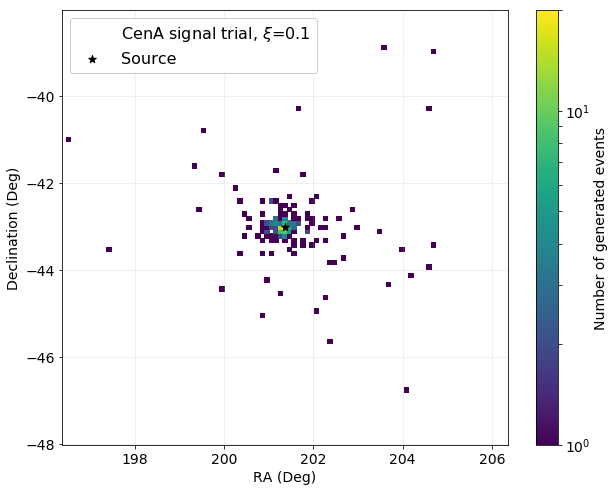

In [4]:
# -----------------------------------------------
# Give the coordinates for CenA in degrees
# -----------------------------------------------
dec_deg, ra_deg = -43.0192, 201.3625

# -----------------------------------------------
# Actually produce IceCube signal events from the 
# public data and your choice of model
# -----------------------------------------------
events = sigGen.generate_pointsource(declination_deg = dec_deg, 
                                    right_ascension_deg = ra_deg,
                                    integral_flux_function = integral_flux_from_file)
print("Generated {} signal events".format(len(events)))

# For plotting, let's wrap the RA to be [0, 2pi]
events['ra'] = events['ra'] % (2*np.pi)

# -----------------------------------------------
# Plot the true position of CenA
# -----------------------------------------------
fig, ax = plt.subplots(figsize=(10, 8))
_ = ax.scatter(ra_deg, dec_deg, 
               color='k', 
               marker='*',
               s=64,
               label='Source',
               zorder=100)

# -----------------------------------------------
# And the reconstructed position of each signal event
# observed from this simulated trial
# -----------------------------------------------
ra_bins = np.linspace(ra_deg-5, ra_deg+5, 100)
delta_dec = np.max(np.abs(dec_deg-np.degrees(events['dec'])))
dec_bins = np.linspace(dec_deg-5, dec_deg+5, 100)

h, _, _ = np.histogram2d(np.degrees(events['ra']),
                         np.degrees(events['dec']),
                         bins=(ra_bins, dec_bins))
cmesh = ax.pcolormesh(ra_bins, dec_bins, h.T,
                      norm=LogNorm()
                      )
cbar = plt.colorbar(cmesh, ax=ax)
cbar.ax.set_ylabel('Number of generated events', fontsize=14)
cbar.ax.tick_params(labelsize=14)


# -----------------------------------------------
# Label the plot and dress it up a bit
# -----------------------------------------------
ax.plot([],[], 
        color='w',
        label=r'CenA signal trial, $\xi$=0.1')
ax.legend(loc='upper left', framealpha=1, fontsize=16)
ax.grid(alpha=0.25)
ax.set_xlim(ra_bins.min(), ra_bins.max())
ax.set_ylim(dec_bins.min(), dec_bins.max())
ax.tick_params(labelsize=14)
ax.set_xlabel("RA (Deg)", fontsize=14)
ax.set_ylabel(r"Declination (Deg)", fontsize=14)

# Generate signal+bg events

The previous block only generated signal events. Here, we overlay background events as well. For background, we follow IceCube's strategy of scrambling (= randomizing) the RA values, which works because of IceCube's unique location at the South Pole. 

Generated 218 signal events and 761380 total events across the full sky


Text(0,0.5,'Declination (Deg)')

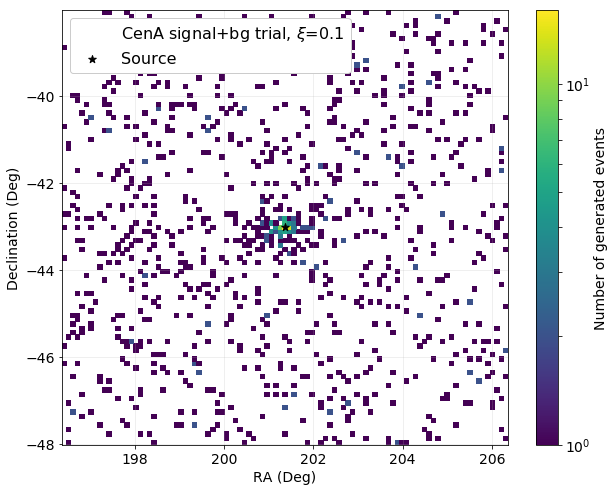

In [5]:
# -----------------------------------------------
# Give the coordinates for CenA in degrees
# -----------------------------------------------
dec_deg, ra_deg = -43.0192, 201.3625

# -----------------------------------------------
# Actually produce IceCube signal events from the 
# public data and your choice of model
# -----------------------------------------------
sig_events = sigGen.generate_pointsource(declination_deg = dec_deg, 
                                        right_ascension_deg = ra_deg,
                                        integral_flux_function = integral_flux_from_file)
bg_events = bgGen.scramble()
events = pd.concat((sig_events, bg_events))

print("Generated {} signal events and {} total events across the full sky".format(len(sig_events), 
                                                                                  len(events)))

# For plotting, let's wrap the RA to be [0, 2pi]
events['ra'] = events['ra'] % (2*np.pi)

# -----------------------------------------------
# Plot the true position of CenA
# -----------------------------------------------
fig, ax = plt.subplots(figsize=(10, 8))
_ = ax.scatter(ra_deg, dec_deg, 
               color='k', 
               marker='*',
               s=64,
               label='Source',
               zorder=100)

# -----------------------------------------------
# And the reconstructed position of each signal event
# observed from this simulated trial
# -----------------------------------------------
ra_bins = np.linspace(ra_deg-5, ra_deg+5, 100)
delta_dec = np.max(np.abs(dec_deg-np.degrees(events['dec'])))
dec_bins = np.linspace(dec_deg-5, dec_deg+5, 100)

h, _, _ = np.histogram2d(np.degrees(events['ra']),
                         np.degrees(events['dec']),
                         bins=(ra_bins, dec_bins))
cmesh = ax.pcolormesh(ra_bins, dec_bins, h.T,
                      norm=LogNorm()
                      )
cbar = plt.colorbar(cmesh, ax=ax)
cbar.ax.set_ylabel('Number of generated events', fontsize=14)
cbar.ax.tick_params(labelsize=14)

# -----------------------------------------------
# Label the plot and dress it up a bit
# -----------------------------------------------
ax.plot([],[], 
        color='w',
        label=r'CenA signal+bg trial, $\xi$=0.1')
ax.legend(loc='upper left', framealpha=1, fontsize=16)
ax.grid(alpha=0.25)
ax.set_xlim(ra_bins.min(), ra_bins.max())
ax.set_ylim(dec_bins.min(), dec_bins.max())
ax.tick_params(labelsize=14)
ax.set_xlabel("RA (Deg)", fontsize=14)
ax.set_ylabel(r"Declination (Deg)", fontsize=14)